In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import sqlite3
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths
from visualizations import viz_scatterplot_correlation, viz_sideways, relative_positive_negative, viz_gender_target
from sum_stats import sum_up_attributes

In [2]:
bls_gender_race_excel_path = data_path / "bls" / "gender_race_hispanic" / "cpsaat11_gender, races, hispanic.xlsx"

gender_race_df = pd.read_excel(bls_gender_race_excel_path, skiprows = 6)

# overall labor market participation
women = gender_race_df["Unnamed: 2"][0]/100
white = gender_race_df["Unnamed: 3"][0]/100
african_american = round(gender_race_df["Unnamed: 4"][0]/100, 3)
asian = gender_race_df["Unnamed: 5"][0]/100
hispanic = gender_race_df["Unnamed: 6"][0]/100

employment_dict = {"women": women, "white": white, "non_hispanic_white": white - hispanic,
                "african_american": african_american, "asian": asian, "hispanic": hispanic}
employment_dict

{'women': 0.47,
 'white': 0.775,
 'non_hispanic_white': 0.595,
 'african_american': 0.123,
 'asian': 0.066,
 'hispanic': 0.18}

In [3]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

# add a column for non-hispanic white people
if "non_hispanic_white" not in df:
    df.insert(8, "non_hispanic_white", df["white"].subtract(df["hispanic"]))

# Naive assumption that 1-women == men
if "men" not in df:
    df.insert(6, "men", (df["women"] - 1).abs())
    
print("The number of entries:", len(df))

The number of entries: 798


In [4]:
# adding the _summed corresponding values
for i in ["women", "white", "non_hispanic_white", "african_american", "asian", "hispanic"]:
    new_col_name = i + "_summed"
    sum_up_attributes(i, new_col_name, df)

df_major = df.loc[df['occ_group'] == "major"] # only majors -> redundant as above code removes non-major anyways

In [5]:
articles_per_detailed = amount_detailed(df_all, df_major)
unique_auths, page_lengths = avg_unique_auth_page_lengths(df_major)

if "art_per_detailed" not in df_major:
    df_major.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_major:
    df_major.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_page_lengths" not in df_major:
    df_major.insert(8, "avg_page_lengths", page_lengths)
    
df_major

,occ_code,occ_group,occ_title,lenient_links,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_page_lengths,men,...,non_hispanic_white,african_american,asian,hispanic,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,0.591,...,0.711,0.086,0.065,0.111,0.412,0.827857,0.716143,0.080143,0.065571,0.111714
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,0.452,...,0.677,0.105,0.086,0.103,0.496714,0.755,0.650714,0.114429,0.092143,0.104286
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,0.738,...,0.571,0.085,0.233,0.083,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143
165,17-0000,major,Architecture and Engineering Occupations,"[[""Engineer"", ""http://en.wikipedia.org/?curid=...",0.416667,"{""Engineer"": [{""revid"": 194559099, ""user"": ""68...",642.666667,"{""Engineer"": 46284, ""Technologist"": 1755, ""Lan...",17190.933333,0.826,...,0.671,0.058,0.146,0.099,0.155,0.784,0.685333,0.043333,0.152333,0.098667
226,19-0000,major,"Life, Physical, and Social Science Occupations","[[""Conservation scientist"", ""http://en.wikiped...",0.395833,"{""Conservation scientist"": [{""revid"": 93806143...",500.684211,"{""Conservation scientist"": 29473, ""Biochemist""...",17686.263158,0.526,...,0.663,0.074,0.152,0.083,0.749,0.846,0.782,0.056,0.054,0.064
305,21-0000,major,Community and Social Service Occupations,"[[""Community health worker"", ""http://en.wikipe...",0.529412,"{""Community health worker"": [{""revid"": 2807264...",270.222222,"{""Community health worker"": 37444, ""Genetic co...",60515.888889,0.325,...,0.604,0.197,0.038,0.125,0.52575,0.75075,0.63125,0.1815,0.03275,0.1195
331,23-0000,major,Legal Occupations,"[[""Lawyer"", ""http://en.wikipedia.org/?curid=17...",1.125000,"{""Lawyer"": [{""revid"": 53322369, ""user"": ""Graem...",660.555556,"{""Lawyer"": 94101, ""Magistrate"": 40682, ""Law cl...",38456.000000,0.465,...,0.736,0.081,0.048,0.104,0.6135,0.83,0.6925,0.083,0.049,0.1375
346,25-0000,major,Educational Instruction and Library Occupations,"[[""Library technician"", ""http://en.wikipedia.o...",0.093750,"{""Library technician"": [{""revid"": 230002599, ""...",775.000000,"{""Library technician"": 6529, ""Teacher"": 63427,...",38508.833333,0.263,...,0.707,0.099,0.056,0.108,0.799,0.867,0.83,0.071,0.037,0.037
443,27-0000,major,"Arts, Design, Entertainment, Sports, and Media...","[[""Handicraft"", ""http://en.wikipedia.org/?curi...",0.756098,"{""Handicraft"": [{""revid"": 90415092, ""user"": ""M...",629.645161,"{""Handicraft"": 15364, ""Designer"": 3819, ""Autho...",16148.903226,0.500,...,0.718,0.082,0.057,0.111,0.4618,0.8148,0.7276,0.0941,0.0569,0.0872
505,29-0000,major,Healthcare Practitioners and Technical Occupat...,"[[""Veterinarian"", ""http://en.wikipedia.org/?cu...",0.478873,"{""Veterinarian"": [{""revid"": 355129330, ""user"":...",450.088235,"{""Veterinarian"": 50710, ""Psychiatrist"": 14239,...",23395.294118,0.257,...,0.662,0.120,0.095,0.094,0.724737,0.795053,0.685947,0.109474,0.063684,0.109105


In [6]:
list(df_major.columns[-11:]) # all possible target_variables

['white',
 'non_hispanic_white',
 'african_american',
 'asian',
 'hispanic',
 'women_summed',
 'white_summed',
 'non_hispanic_white_summed',
 'african_american_summed',
 'asian_summed',
 'hispanic_summed']

In [7]:
"art_per_detailed", "avg_unique_auths", "avg_page_lengths"

('art_per_detailed', 'avg_unique_auths', 'avg_page_lengths')

Pearsons correlation is 0.338


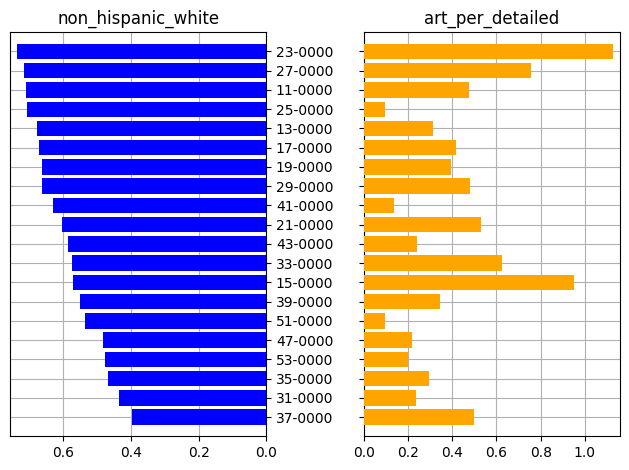

In [8]:
target_var = "non_hispanic_white"

second_var = "art_per_detailed"

viz_sideways(df_major, target_var, second_var)

In [9]:
# viz_scatterplot_correlation(df_major, target_var, second_var)
# relative_positive_negative(df_major, "women", employment_dict)

Only for the gender " MEN "
Pearsons correlation is 0.250
Only for the gender " WOMEN "
Pearsons correlation is 0.014


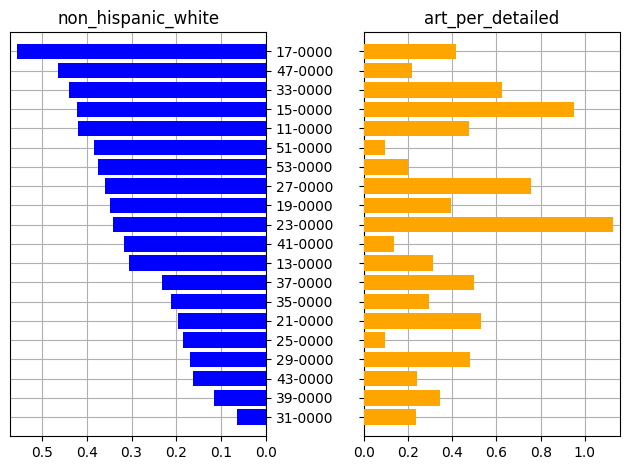

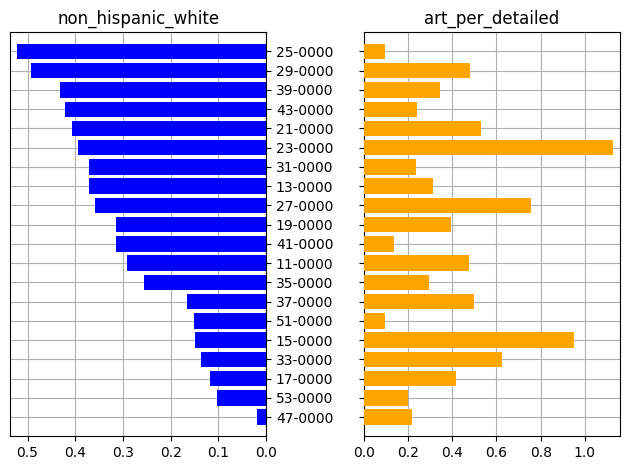

In [12]:
viz_gender_target(df_major, target_var, second_var, "men")

viz_gender_target(df_major, target_var, second_var, "women")